# Ising model transition: detection with ML algorithms

In this notebook, we will apply some classification algorithms to our Monte Carlo data. First we will load the binned configurations we saved during our Monte Carlo measurement sweeps. Since the Ising model transition temerature is exactly known, $T_c \approx 2.269$, we can label each configuration as belonging to either the ordered or disordered regime. We can then apply binary classification techniques, such as K-Nearest Neighbors, Support Vector Classifier, and various tree-based methods to learn to classify unseen spin configurations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier

## 1. Load configurations + data visualization

In [4]:
data = np.loadtxt('.\\data\\binned_configurations_array.csv', delimiter=',')

In [5]:
X = data[:, :-1]
T = data[:, -1]

In [6]:
X.shape  # 41 temperatures, 100 samples each. 12x12 lattice with 144 sites.

(4100, 144)

In [7]:
T.shape   # Single label (temperature) for each sample

(4100,)

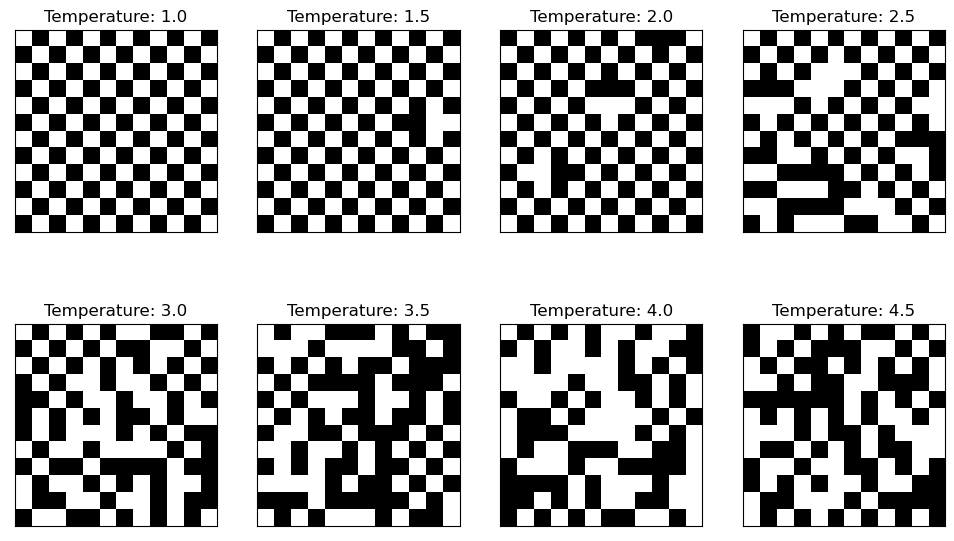

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(12, 7))
index = 0

for i in range(2):
    for j in range(4):

        axs[i, j].imshow(X[index*500].reshape(12, 12), cmap="binary", origin='lower')
        #axs[i, j].set_xticks(list(range(12)))
        #axs[i, j].set_yticks(list(range(12)))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(f'Temperature: {T[index*500]}')
        #axs[i, j].axis('off')
        index += 1

## 2. Test/train split + transforming target labels

In [9]:
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.3, random_state=1, shuffle=True)

#scaler = StandardScaler()
#scaler.fit(X_train)
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)

y_train = (T_train < 2.269).astype(int)
y_test = (T_test < 2.269).astype(int)

In [10]:
X_train.shape

(2870, 144)

In [11]:
y_train.shape

(2870,)

In [12]:
X_test.shape

(1230, 144)

In [13]:
y_test.shape

(1230,)

## 3.1. KNN Classifier:

In [15]:
knn = GridSearchCV(KNeighborsClassifier(), param_grid={"n_neighbors":list(range(1, 20)), "weights":["uniform", "distance"]}, cv=10, scoring="accuracy", verbose=1)
knn.fit(X_train, y_train)

Fitting 10 folds for each of 38 candidates, totalling 380 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [16]:
print("KNN best parameters: ")
print(knn.best_params_)

KNN best parameters: 
{'n_neighbors': 2, 'weights': 'uniform'}


In [35]:
best_knn = KNeighborsClassifier(n_neighbors=2, weights='uniform')
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [36]:
y_pred_best_knn = best_knn.predict(X_test)
best_knn_accuracy = best_knn.score(X_test, y_test)
print(best_knn_accuracy)

0.908130081300813






Classification Report for KNN classifier: 

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       826
           1       0.79      0.99      0.88       404

    accuracy                           0.91      1230
   macro avg       0.89      0.93      0.90      1230
weighted avg       0.93      0.91      0.91      1230




Confusion Matrix for KNN classifier: 



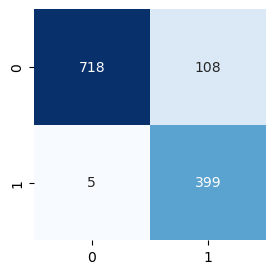

In [37]:
print('\n\n\n')
print('Classification Report for KNN classifier: \n')
print(classification_report(y_test, y_pred_best_knn))
print('\n\n')
print('Confusion Matrix for KNN classifier: \n')
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_pred_best_knn), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.show()

## 3.2. Random Forest:

In [20]:
rfc = GridSearchCV(RandomForestClassifier(), param_grid={"n_estimators":[50, 100, 150], 'max_depth': range (2, 10, 1)}, cv=10, scoring="accuracy", verbose=1)
rfc.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 10),
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=1)

In [21]:
print("RFC best parameters: ")
print(rfc.best_params_)

RFC best parameters: 
{'max_depth': 4, 'n_estimators': 150}


In [38]:
best_rfc = RandomForestClassifier(n_estimators=150, max_depth=4)
best_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=150)

In [39]:
y_pred_best_rfc = best_rfc.predict(X_test)
best_rfc_accuracy = best_rfc.score(X_test, y_test)
print(best_rfc_accuracy)

0.9650406504065041






Classification Report for RFC classifier: 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       826
           1       0.96      0.94      0.95       404

    accuracy                           0.97      1230
   macro avg       0.96      0.96      0.96      1230
weighted avg       0.96      0.97      0.96      1230




Confusion Matrix for RFC classifier: 



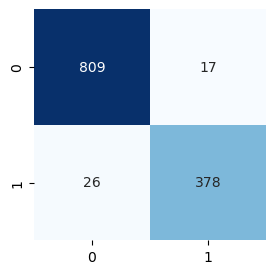

In [40]:
print('\n\n\n')
print('Classification Report for RFC classifier: \n')
print(classification_report(y_test, y_pred_best_rfc))
print('\n\n')
print('Confusion Matrix for RFC classifier: \n')
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_pred_best_rfc), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.show()

## 3.3 Support Vector Classifier

In [25]:
svc = GridSearchCV(SVC(), param_grid={'C':[0.1, 0.5, 1.0], 'gamma':['scale', 'auto', 0.001, 0.1], 'class_weight':['balanced', None]}, cv=10, verbose=1, scoring='accuracy')
svc.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1.0],
                         'class_weight': ['balanced', None],
                         'gamma': ['scale', 'auto', 0.001, 0.1]},
             scoring='accuracy', verbose=1)

In [26]:
print("SVC best parameters: ")
print(svc.best_params_)

SVC best parameters: 
{'C': 1.0, 'class_weight': None, 'gamma': 'scale'}


In [41]:
best_svc = SVC(C=1, gamma='scale', class_weight=None)
best_svc.fit(X_train, y_train)

SVC(C=1)

In [42]:
y_pred_best_svc = best_svc.predict(X_test)
best_svc_accuracy = best_svc.score(X_test, y_test)
print(best_svc_accuracy)

0.9658536585365853






Classification Report for SVC classifier: 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       826
           1       0.95      0.94      0.95       404

    accuracy                           0.97      1230
   macro avg       0.96      0.96      0.96      1230
weighted avg       0.97      0.97      0.97      1230




Confusion Matrix for SVC classifier: 



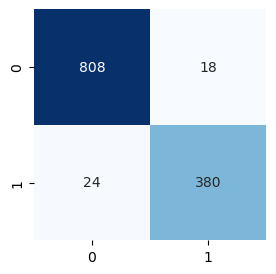

In [43]:
print('\n\n\n')
print('Classification Report for SVC classifier: \n')
print(classification_report(y_test, y_pred_best_svc))
print('\n\n')
print('Confusion Matrix for SVC classifier: \n')
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_pred_best_svc), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.show()

## 3.4. XGBoost classifier

In [30]:
xgb = GridSearchCV(XGBClassifier(), param_grid={'max_depth': range (2, 10, 1), 'n_estimators':[100, 150, 200], 'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.001]}, cv=10, scoring='accuracy', verbose=1)
xgb.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.001],
                         'max_depth': range(2, 10),
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=1)

In [31]:
print("XGB best parameters: ")
print(xgb.best_params_)

XGB best parameters: 
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


In [44]:
best_xgb = XGBClassifier(learning_rate=0.2, max_depth=5, n_estimators=200)
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
y_pred_best_xgb = best_xgb.predict(X_test)
best_xgb_accuracy = best_xgb.score(X_test, y_test)
print(best_xgb_accuracy)

0.9626016260162602






Classification Report for XGB classifier: 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       826
           1       0.95      0.93      0.94       404

    accuracy                           0.96      1230
   macro avg       0.96      0.96      0.96      1230
weighted avg       0.96      0.96      0.96      1230




Confusion Matrix for XGB classifier: 



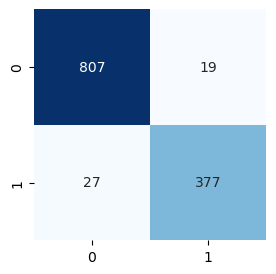

In [46]:
print('\n\n\n')
print('Classification Report for XGB classifier: \n')
print(classification_report(y_test, y_pred_best_xgb))
print('\n\n')
print('Confusion Matrix for XGB classifier: \n')
plt.figure(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='g', cmap='Blues', cbar=False)
plt.show()

## 4. Evaluation on test set + analyzing errors

In [47]:
print('Classifier            Test set accuracy\n')
print(f'K Nearest Neighbors        {best_knn_accuracy:.4f}   ')
print(f'Random Forest              {best_rfc_accuracy:.4f}   ')
print(f'Support Vector Classifier  {best_svc_accuracy:.4f}   ')
print(f'XGBoost                    {best_xgb_accuracy:.4f}   ')

Classifier            Test set accuracy

K Nearest Neighbors        0.9081   
Random Forest              0.9650   
Support Vector Classifier  0.9659   
XGBoost                    0.9626   


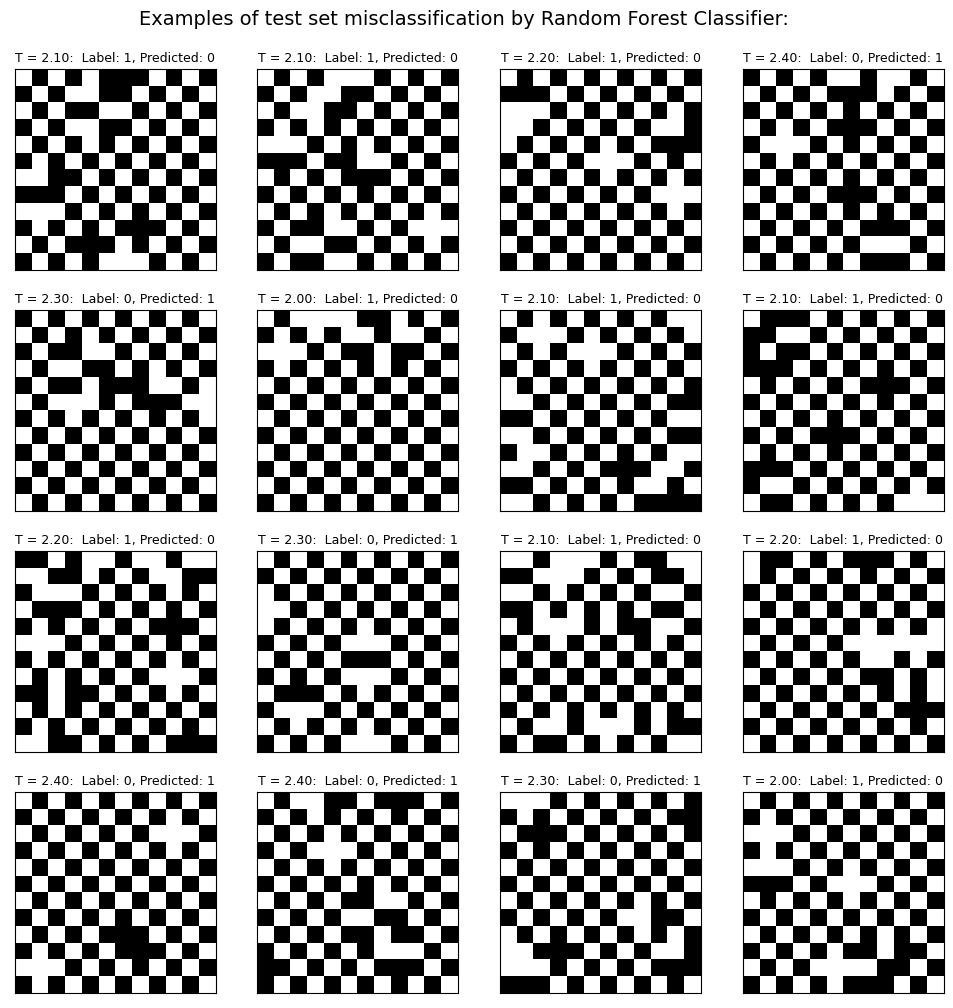

In [48]:
is_correct = (y_pred_best_rfc == y_test)
misclassified = np.where(is_correct == False)[0]

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
index = 0

for i in range(4):
    for j in range(4):
    
        sample_num = misclassified[index]
    
        axs[i, j].imshow(X_test[sample_num].reshape(12, 12), cmap="binary")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(f'T = {T_test[sample_num]:.2f}:  Label: {y_test[sample_num]}, Predicted: {y_pred_best_rfc[sample_num]}', fontsize=9)
        
        index += 1

plt.suptitle('Examples of test set misclassification by Random Forest Classifier:', y=0.93, fontsize=14)
plt.show()

## 5. Summary

1. Random Forest, XGBoost, and SVC all perform similarly well on this dataset (144 site Ising model) with approximately 96% accuracy. 


2. However, target labels ($y=0$ and $y=1$) are based on exact result for the 2D Ising model ($T_c \approx 2.269$) in the thermodynamic limit, thus is not exact for our finite size lattice.


3. Note: 400 out of 4100 configurations in the dataset (9.76%) represent temperatures in the range $T=2.1$ to $T=2.4$ (inclusive), which are in the vicinity of $T_c$. For small lattices, a sharp transition at $T_c \approx 2.269$ will not be observed, hence configurations slightly above and below $T_c$ will look similar. 


4. As expected, most misclassified samples come from this temperature range ($T=2.1$ to $T=2.4$), as shown above.